In [18]:
import numpy as np
import cv2
import urllib.request as urllib
from matplotlib import pyplot as plt
from pytesseract import image_to_string
import pytesseract
from random import randrange 
from easyocr import Reader

In [24]:
def find_number_contours(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    biggest_contour = None
    biggest_contour_area = -1
    second_biggest=None

    for contour in contours:
        contourArea = cv2.contourArea(contour)
        if contourArea > biggest_contour_area:
            second_biggest=biggest_contour
            biggest_contour_area = contourArea
            biggest_contour = contour
    if second_biggest is not None:
        return second_biggest, hierarchy
    elif biggest_contour is not None:
        return biggest_contour, hierarchy

    return None, None

def preprocess_digit_image(img):
    kernel = np.ones((3,3),np.uint8)
    fill_color = [255,255,255]
    mask_value = 255
    h, w = img.shape
    img = cv2.medianBlur(img,5)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                                    cv2.THRESH_BINARY,11,2)
    contours, hierarchy = find_number_contours(img)
    img_color = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    ret=None
    if contours is not None and hierarchy is not None:
        cv2.drawContours(img_color, [contours], 0, (255, 0, 0), 2, cv2.LINE_8, hierarchy, 0)
        stencil  = np.zeros(img_color.shape[:-1]).astype(np.uint8)
        cv2.fillPoly(stencil, [contours], mask_value)
        sel = stencil != mask_value # select everything that is not mask_value
        if (cv2.contourArea(contours) / (img.shape[0]*img.shape[1]))*100 >= 9:
            img_color[sel] = fill_color
        else:
            img_color[:] = fill_color
        ret = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
        _, ret = cv2.threshold(ret, 50, 255, cv2.THRESH_OTSU)
    else:
        ret = img
    return ret

def detect_hough_lines(img, thr, min_line_length, max_line_gap):
    image = img.copy()
    gray = image
    denoised_img = cv2.fastNlMeansDenoising(gray)
    
    edges = cv2.Canny(denoised_img,5,150,apertureSize = 3)
    
    kernel = np.ones((3,3),np.uint8)
    edges = cv2.dilate(edges,kernel,iterations = 1)
    
    kernel = np.ones((5,5),np.uint8)
    edges = cv2.dilate(edges,kernel,iterations = 1)
    
    lines = cv2.HoughLinesP(edges,rho = 1,theta = 1*np.pi/180,threshold = thr,minLineLength = min_line_length,maxLineGap = max_line_gap)

    for i in range(0, len(lines)):
        l = lines[i][0]
        cv2.line(image, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
    return image


def _mean(img):
    row, col = img.shape
    avg = 0
    count = 0
    for i in range(row):
        for j in range(col):
            pix = img[i][j]
            if pix > 50:
                avg += pix
                count += 1
    return (avg / count)

def enlarge_borders(img, size=5):
    row, col = img.shape[:2]
    bottom = img[row-2:row, 0:col]
    mean = _mean(bottom)
    white=[255,255,255]

    bordersize = size
    return cv2.copyMakeBorder(
        img,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT, 
        value=[mean,mean,mean]
    )

def predict_digit(img, easy_ocr_reader):
    img = preprocess_digit_image(img)
    res = image_to_string(img, config="--psm 10 digits")
    
    if len(res) > 1:
        if res[:1].isnumeric():
            return int(res[0])
    elif res.isnumeric():
            return int(res[0])
        
    res = easy_ocr_reader.readtext(img, allowlist='123456789')
    if res:
        res = res[0][1]
        if len(res) > 1:
            if res[:1].isnumeric():
                return int(res[0])
        elif res.isnumeric():
                return int(res[0])
        
    kernel = np.ones((3,3),np.uint8)
    img = cv2.erode(img,kernel,iterations = 1)
    
    res = image_to_string(img, config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
    
    if len(res) > 1:
        if res[:1].isnumeric():
            return int(res[0])
    elif res.isnumeric():
            return int(res[0])
    
    h, w = img.shape 
    x1 = int(w / 5)
    y1 = int(h / 5)
    x2 = w - x1
    y2 = h - y1
    cropped = img[y1:y2, x1:x2]
    perc = 100 - (cv2.countNonZero(cropped) / (cropped.shape[0] * cropped.shape[1]) * 100)
    
    if perc >= 50:
        return 9
    
    return -1

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


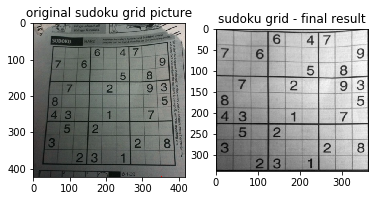

In [25]:
class SudokuGrid:
    
    def __init__(self, filepath):
        self.img = cv2.imread(filepath)
        self.gray = cv2.cvtColor(self.img,cv2.COLOR_BGR2GRAY)
        self.full_res_grid = None
        self.reader = Reader(['en'])
        pytesseract.pytesseract.tesseract_cmd = 'C:\\Users\\boris\\AppData\\Local\\Programs\\Tesseract-OCR\\tesseract.exe'
        
    def preprocess(self):
        disk_se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
        bh_res = cv2.morphologyEx(self.gray, cv2.MORPH_BLACKHAT, disk_se)
        otsu, bh_res = cv2.threshold(bh_res, 50, 255, cv2.THRESH_OTSU)
        self.bh_res = bh_res
        return bh_res
        
        
    def find_contours(self, edges):
        contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        biggest_contour = None
        biggest_contour_area = -1

        for contour in contours:
            contourArea = cv2.contourArea(contour)
            if contourArea > biggest_contour_area:
                epsilon = 0.1 * cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour,epsilon,True)
                if len(approx) == 4:
                    biggest_contour_area = contourArea
                    biggest_contour = contour
        
        if biggest_contour is not None:
            return contours, biggest_contour, hierarchy
        
        return None
    
    def find_vertices(self, contours):
        # approximation of the grid shape
        epsilon = 0.1 * cv2.arcLength(contours, True)
        approx = cv2.approxPolyDP(contours,epsilon,True)
        
        pts = approx.reshape(4, 2)
        rect = np.zeros((4, 2), dtype = "float32")
        
        # the top-left point has the smallest sum whereas the
        # bottom-right has the largest sum
        s = pts.sum(axis = 1)
        
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        
        # compute the difference between the points 
        # the top-right will have the minumum difference and
        # the bottom-left will have the maximum difference
        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        
        return rect
    
    def warp(self, contours):
        vertices = self.find_vertices(contours)
        
        (top_left, top_right, bottom_right, bottom_left) = vertices
        
        # distance between the bottom right / bottom left points and top right / top left points
        widthA = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
        widthB = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
        
        # distance between the top right / bottom right points and top left / bottom left points
        heightA = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
        heightB = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))
        
        maxWidth = max(int(widthA), int(widthB))
        maxHeight = max(int(heightA), int(heightB))
        
        warped_vertices = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype = "float32")
        
        M = cv2.getPerspectiveTransform(vertices, warped_vertices)
        warped = cv2.warpPerspective(self.gray, M, (maxWidth, maxHeight))
        self.bh_res = cv2.warpPerspective(self.bh_res, M, (maxWidth, maxHeight))
        return warped
        
    def generate_full_res(self):
        
        self.edges = self.preprocess()
        all_contours, contours, hierarchy = self.find_contours(self.edges)
        
        self.full_res_grid = self.warp(contours)
        
        cv2.drawContours(self.img, all_contours, 0, (255,0,0), 2, cv2.LINE_8, hierarchy, 0)
        
        return self.full_res_grid
    
    def extract_digits(self):
        wo_hough_lines = detect_hough_lines(self.bh_res, 80, 80, 0)
        wo_hough_lines += detect_hough_lines(self.bh_res, 100, 30, 0)
        canny_output = cv2.Canny(wo_hough_lines, 255, 255 * 2)
        kernel = np.ones((3,3),np.uint8)
        canny_output = cv2.dilate(canny_output,kernel,iterations = 1)
        contours, hierarchy = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        out = np.zeros_like(wo_hough_lines)
        grid_height, grid_width = self.bh_res.shape
        final_grid = [[ None for x in range(9)] for y in range(9)]

        for i, cnt in enumerate(contours):
            x,y,w,h = cv2.boundingRect(cnt)
            if (abs(w - h) < 10 or 2.2 >= max(w,h) / min(w,h) >= 1.8 ) and cv2.contourArea(cnt) > 100:
                pos_x = x + (w / 2)
                pos_grid_x = pos_x / (grid_width / 9)
                pos_grid_x = int(pos_grid_x)
                pos_y = y + (h / 2)
                pos_grid_y = pos_y / (grid_height / 9)
                pos_grid_y = int(pos_grid_y)
                final_grid[pos_grid_y][pos_grid_x] = self.full_res_grid[y:y+h, x:x+w]
                out[y:y+h, x:x+w] = self.full_res_grid[y:y+h, x:x+w]

        return final_grid,out
    
    def get_array(self):
        final_grid, out = self.extract_digits()
        self.result_grid = [[ None for x in range(9)] for y in range(9)]
        for i, a in enumerate(final_grid):
                for j, x in enumerate(a):
                    if x is not None:
                        enlarged = enlarge_borders(x)
                        pred = predict_digit(enlarged, self.reader)
                        self.result_grid[i][j] = pred
        return self.result_grid


#sudoku_grid = SudokuGrid('images/picture_2.jpeg')
sudoku_grid = SudokuGrid('images/sudoku.jpg')
full_res = sudoku_grid.generate_full_res()

plt.subplot(121), plt.imshow(sudoku_grid.img)
plt.title('original sudoku grid picture')
plt.subplot(122), plt.imshow(full_res, cmap='gray')
plt.title('sudoku grid - final result')
plt.show()

In [26]:
display_array = []
result_grid = sudoku_grid.get_array()

for line in result_grid:
    a=[]
    for cell in line:
        if cell is None:
            a.append(' ')
        else:
            a.append(str(cell))
    display_array.append(a)
    
for line in display_array:
    print(line)

[' ', ' ', ' ', '6', ' ', '4', '7', ' ', ' ']
['7', ' ', '6', ' ', ' ', ' ', ' ', ' ', '9']
[' ', ' ', ' ', ' ', ' ', '5', ' ', '8', ' ']
[' ', '7', ' ', ' ', '2', ' ', ' ', '9', '3']
['8', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '5']
['4', '3', ' ', ' ', '1', ' ', ' ', '7', ' ']
[' ', '5', ' ', '2', ' ', ' ', ' ', ' ', ' ']
['3', ' ', ' ', ' ', ' ', ' ', '2', ' ', '8']
[' ', ' ', '2', '3', ' ', '1', ' ', ' ', ' ']
